In [1]:
import pandas as pd
import random
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import calendar
import numpy as np

Downloaded data from: http://web.mta.info/developers/turnstile.html

Documentations at: http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt

Map of the MTA system: http://web.mta.info/maps/submap.html

In [2]:
df = pd.read_csv('turnstile_180526.txt')

Fix 'EXITS' column name (it has many spaces at the end of it)

In [3]:
# old_exit_name = df.columns[-1]
df.rename(columns={df.columns[-1]: 'EXITS'}, inplace = True)

In [4]:
backup_df = df.copy()

In [5]:
# this is slow...FYI
df['DATETIME'] = pd.to_datetime(df.DATE + ' ' + df.TIME, format='%m/%d/%Y %H:%M:%S')
df['DATE'] = pd.to_datetime(df['DATE'], format='%m/%d/%Y')

In [6]:
df['STATION_KEY'] = df['C/A'] + ' ' + df['UNIT'] + ' ' + df['STATION']

In [ ]:
# cols_to_drop = ['C/A','UNIT','STATION']
# cols_to_drop = ['C/A','UNIT']
# df.drop(cols_to_drop, axis=1, inplace=True)

Sort, Group by Station Key, then compute difference between 'ENTRIES'

In [7]:
# need this
df.sort_values(['STATION_KEY', 'SCP', 'DATETIME'], inplace=True)

In [ ]:
df['ENTRY_DIFFS'] = df.groupby(['STATION_KEY','SCP'])['ENTRIES'].diff(periods=-1)*-1

In [10]:
df['EXIT_DIFFS'] = df.groupby(['STATION_KEY','SCP'])['EXITS'].diff(periods=-1)*-1

The majority of 'ENTRY_DIFFS' values are reasonable, but there are still some large negative and positive values still. For now, exclude them from our analysis. (There shouldn't, in fact, be any negative values.)

In [11]:
# 200,000 entries per day is a reasonable cut-off
clean_df = df[(df['ENTRY_DIFFS'] < 2E5) 
              & (df['ENTRY_DIFFS'] > 0) 
              & (df['EXIT_DIFFS'] < 2E5)
              & (df['EXIT_DIFFS'] > 0)]

(array([  1.43960000e+05,   9.80400000e+03,   1.93600000e+03,
          5.23000000e+02,   1.72000000e+02,   4.70000000e+01,
          2.00000000e+01,   5.00000000e+00,   5.00000000e+00,
          1.00000000e+00]),
 array([  1.00000000e+00,   4.80600000e+02,   9.60200000e+02,
          1.43980000e+03,   1.91940000e+03,   2.39900000e+03,
          2.87860000e+03,   3.35820000e+03,   3.83780000e+03,
          4.31740000e+03,   4.79700000e+03]),
 <a list of 10 Patch objects>)

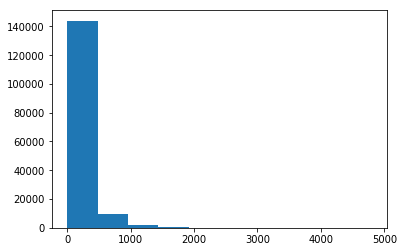

In [14]:
plt.hist(clean_df['EXIT_DIFFS'].dropna())

(array([  1.20340000e+05,   2.51650000e+04,   7.43600000e+03,
          2.26400000e+03,   8.29000000e+02,   2.89000000e+02,
          8.10000000e+01,   5.10000000e+01,   1.50000000e+01,
          3.00000000e+00]),
 array([  1.00000000e+00,   3.28800000e+02,   6.56600000e+02,
          9.84400000e+02,   1.31220000e+03,   1.64000000e+03,
          1.96780000e+03,   2.29560000e+03,   2.62340000e+03,
          2.95120000e+03,   3.27900000e+03]),
 <a list of 10 Patch objects>)

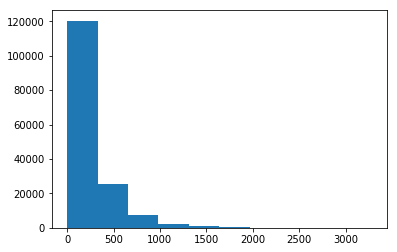

In [13]:
plt.hist(clean_df['ENTRY_DIFFS'].dropna())

(array([  1.20340000e+05,   2.51650000e+04,   7.43600000e+03,
          2.26400000e+03,   8.29000000e+02,   2.89000000e+02,
          8.10000000e+01,   5.10000000e+01,   1.50000000e+01,
          3.00000000e+00]),
 array([  1.00000000e+00,   3.28800000e+02,   6.56600000e+02,
          9.84400000e+02,   1.31220000e+03,   1.64000000e+03,
          1.96780000e+03,   2.29560000e+03,   2.62340000e+03,
          2.95120000e+03,   3.27900000e+03]),
 <a list of 10 Patch objects>)

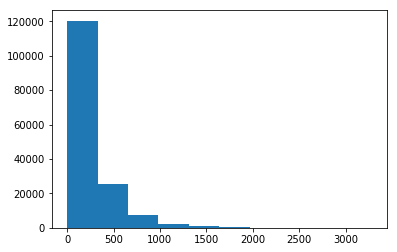

In [13]:
plt.hist(clean_df['ENTRY_DIFFS'].dropna())

In [18]:
grp1 = df.groupby(['STATION_KEY', 'DATE'])['ENTRY_DIFFS','EXIT_DIFFS'].sum().reset_index()

In [19]:
grp1.head()

,STATION_KEY,DATE,ENTRY_DIFFS,EXIT_DIFFS
0,A002 R051 59 ST,2018-05-19,6838.0,3981.0
1,A002 R051 59 ST,2018-05-20,5712.0,3452.0
2,A002 R051 59 ST,2018-05-21,13167.0,8141.0
3,A002 R051 59 ST,2018-05-22,13706.0,8690.0
4,A002 R051 59 ST,2018-05-23,14233.0,8919.0


Take the highest-volume stations and look at them more closely

In [20]:
highest_vol = clean_df.sort_values('ENTRY_DIFFS').tail(100)['STATION_KEY'].unique()

In [21]:
x_labels = calendar.day_name[5:] + calendar.day_name[:5]

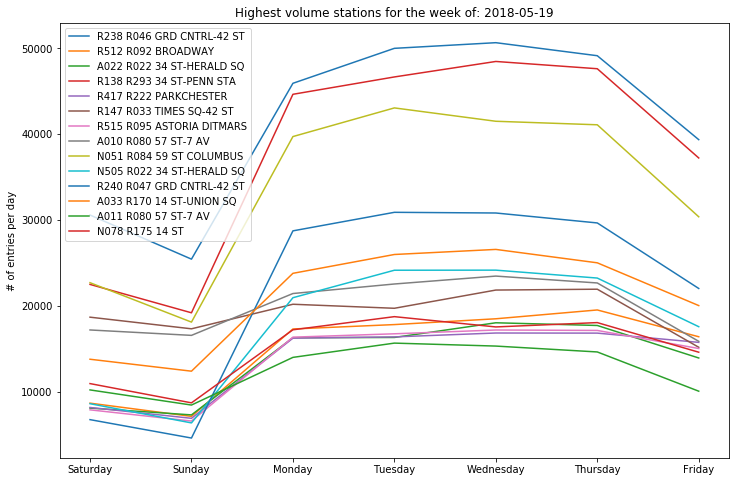

In [22]:
fig, ax = plt.subplots(figsize=[12,8])

for s in highest_vol:
    dum_df = grp1[grp1['STATION_KEY'] == s]
    xs = dum_df['DATE']
    week_start = xs.iloc[0].strftime('%Y-%m-%d')
    plt.plot(xs, dum_df['ENTRY_DIFFS'], label=s)
    xticklocs = ax.get_xticks()
    plt.xticks(xticklocs, x_labels)
    plt.legend()
    plt.ylabel('# of entries per day')
    plt.title('Highest volume stations for the week of: ' + str(week_start));

**Next steps:** 
- determine what we want our "weekday vs weekend" cut-off to be. 
- plot a heatmap of a few of these stations (GRD CENTRAL, ASTORIA DITMARS, e.g.)

In [33]:
def get_station_data(s):
    '''Given station key ,
    returns all entries from cleaned data frame for this station '''
    #d = dt.datetime(d_tuple)
    return clean_df[clean_df['STATION_KEY'] == s]

In [ ]:
def station_datetime(s, d):
    '''Given station key and date,
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    #d = dt.datetime(d_tuple)
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]

In [ ]:
def station_dayints(s, year, month, day):
    '''Given station key and date,
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    d = dt.datetime(year, month, day)
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]

In [23]:
import seaborn as sns

In [ ]:
def get_station_data(s):
    '''Given station key ,
    returns all entries from cleaned data frame for this station '''
    #d = dt.datetime(d_tuple)
    return clean_df[clean_df['STATION_KEY'] == s]

In [39]:
def heatmap_data_old(s, year, month, day):
    '''Given station key and date,c
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    d = dt.datetime(year, month, day)
    return clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)][['DATETIME','ENTRY_DIFFS']]

In [42]:
def heatmap_data(s, year, month, day):
    '''Given station key and date,c
    returns all entries from cleaned data frame for this station & date
    Date is in format (year, month, date)'''
    d = dt.datetime(year, month, day)
    dum_df = clean_df[(clean_df['DATE'] == d) & (clean_df['STATION_KEY'] == s)]
    return dum_df.groupby('DATETIME')['ENTRY_DIFFS'].sum()

In [24]:
gc_key = highest_vol[0]

In [34]:
gc_data = get_station_data(gc_key)

In [35]:
gc_data.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_KEY,ENTRY_DIFFS,EXIT_DIFFS
152751,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,00:00:00,REGULAR,678,7417,2018-05-19 00:00:00,R238 R046 GRD CNTRL-42 ST,13.0,62.0
152752,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,04:00:00,REGULAR,691,7479,2018-05-19 04:00:00,R238 R046 GRD CNTRL-42 ST,9.0,121.0
152753,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,08:00:00,REGULAR,700,7600,2018-05-19 08:00:00,R238 R046 GRD CNTRL-42 ST,60.0,513.0
152754,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,12:00:00,REGULAR,760,8113,2018-05-19 12:00:00,R238 R046 GRD CNTRL-42 ST,108.0,747.0
152755,R238,R046,00-00-00,GRD CNTRL-42 ST,4567S,IRT,2018-05-19,16:00:00,REGULAR,868,8860,2018-05-19 16:00:00,R238 R046 GRD CNTRL-42 ST,104.0,567.0


In [43]:
heatmap_data(gc_key, 2018, 5, 19)

DATETIME
2018-05-19 00:00:00    1778.0
2018-05-19 04:00:00    1132.0
2018-05-19 08:00:00    5631.0
2018-05-19 12:00:00    8925.0
2018-05-19 16:00:00    8736.0
2018-05-19 20:00:00    4367.0
Name: ENTRY_DIFFS, dtype: float64

In [36]:
hm_data = gc_data.groupby('DATETIME')['ENTRY_DIFFS'].sum()

DATETIME
2018-05-19 00:00:00     1778.0
2018-05-19 04:00:00     1132.0
2018-05-19 08:00:00     5631.0
2018-05-19 12:00:00     8925.0
2018-05-19 16:00:00     8736.0
2018-05-19 20:00:00     4367.0
2018-05-20 00:00:00     1388.0
2018-05-20 04:00:00      604.0
2018-05-20 08:00:00     5064.0
2018-05-20 12:00:00     6829.0
2018-05-20 16:00:00     7284.0
2018-05-20 20:00:00     4263.0
2018-05-21 00:00:00      626.0
2018-05-21 04:00:00     4326.0
2018-05-21 08:00:00    11975.0
2018-05-21 12:00:00     8546.0
2018-05-21 16:00:00    13920.0
2018-05-21 20:00:00     6521.0
2018-05-22 00:00:00      687.0
2018-05-22 04:00:00     4564.0
2018-05-22 08:00:00    11276.0
2018-05-22 12:00:00    10331.0
2018-05-22 16:00:00    16474.0
2018-05-22 20:00:00     6647.0
2018-05-23 00:00:00     1303.0
2018-05-23 04:00:00     4446.0
2018-05-23 08:00:00    11503.0
2018-05-23 12:00:00     9947.0
2018-05-23 16:00:00    15888.0
2018-05-23 20:00:00     7557.0
2018-05-24 00:00:00     1428.0
2018-05-24 04:00:00     4208.0

In [48]:
gc_hmdata = [heatmap_data(gc_key, 2018, 5, d) for d in range(19,26)]
# gc_hmdata

In [49]:
gc_hmdata

[DATETIME
 2018-05-19 00:00:00    1778.0
 2018-05-19 04:00:00    1132.0
 2018-05-19 08:00:00    5631.0
 2018-05-19 12:00:00    8925.0
 2018-05-19 16:00:00    8736.0
 2018-05-19 20:00:00    4367.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-20 00:00:00    1388.0
 2018-05-20 04:00:00     604.0
 2018-05-20 08:00:00    5064.0
 2018-05-20 12:00:00    6829.0
 2018-05-20 16:00:00    7284.0
 2018-05-20 20:00:00    4263.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-21 00:00:00      626.0
 2018-05-21 04:00:00     4326.0
 2018-05-21 08:00:00    11975.0
 2018-05-21 12:00:00     8546.0
 2018-05-21 16:00:00    13920.0
 2018-05-21 20:00:00     6521.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-22 00:00:00      687.0
 2018-05-22 04:00:00     4564.0
 2018-05-22 08:00:00    11276.0
 2018-05-22 12:00:00    10331.0
 2018-05-22 16:00:00    16474.0
 2018-05-22 20:00:00     6647.0
 Name: ENTRY_DIFFS, dtype: float64, DATETIME
 2018-05-23 00:00:00     1303.0
 2018-05-23 04:00:00  

In [54]:
len(gc_hmdata[-1]

DATETIME
2018-05-25 00:00:00     1534.0
2018-05-25 04:00:00     3401.0
2018-05-25 08:00:00     9524.0
2018-05-25 12:00:00    11808.0
2018-05-25 16:00:00    13085.0
Name: ENTRY_DIFFS, dtype: float64

In [53]:
gc_hmdata[-1].append(dt.datetime(2018,5,25,20,0,0),5000)

TypeError: cannot concatenate object of type "<class 'datetime.datetime'>"; only pd.Series, pd.DataFrame, and pd.Panel (deprecated) objs are valid

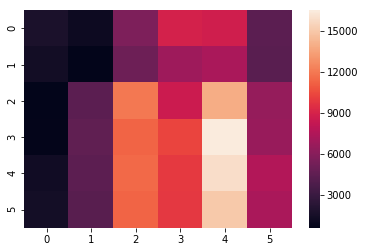

In [51]:
sns.heatmap(gc_hmdata[:-1])

In [47]:
for x in gc_hmdata:
    print(len(x))

6
6
6
6
6
6
5
0


In [30]:
gc_hmdata[:20]

[                  DATETIME  ENTRY_DIFFS
 152751 2018-05-19 00:00:00         13.0
 152752 2018-05-19 04:00:00          9.0
 152753 2018-05-19 08:00:00         60.0
 152754 2018-05-19 12:00:00        108.0
 152755 2018-05-19 16:00:00        104.0
 152756 2018-05-19 20:00:00         24.0
 152793 2018-05-19 00:00:00         21.0
 152794 2018-05-19 04:00:00         12.0
 152795 2018-05-19 08:00:00        143.0
 152796 2018-05-19 12:00:00        185.0
 152797 2018-05-19 16:00:00        131.0
 152798 2018-05-19 20:00:00         57.0
 152835 2018-05-19 00:00:00         27.0
 152836 2018-05-19 04:00:00         10.0
 152837 2018-05-19 08:00:00        160.0
 152838 2018-05-19 12:00:00        209.0
 152839 2018-05-19 16:00:00        161.0
 152840 2018-05-19 20:00:00         50.0
 152877 2018-05-19 00:00:00         18.0
 152878 2018-05-19 04:00:00         21.0
 152879 2018-05-19 08:00:00        138.0
 152880 2018-05-19 12:00:00        209.0
 152881 2018-05-19 16:00:00        130.0
 152882 2018-05-

In [ ]:
dum = 